# Nick Mini-Project 2

Utilising the data from Kaggle's database. This dataset provides a detailed overview of gym members' exercise routines, physical attributes, and fitness metrics. It contains 973 samples of gym data, including key performance indicators such as heart rate, calories burned, and workout duration. Each entry also includes demographic data and experience levels, allowing for comprehensive analysis of fitness patterns, athlete progression, and health trends.


* Importing libraries and loading data:

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Avoid some version change warnings
import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')

In [356]:
gym_csv = '/Users/nickparker/Downloads/gym_members_exercise_tracking.csv'
gym_data = pd.read_csv(gym_csv)

In [358]:
gym_data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


## EDA and Data Visualisation

In [361]:
#Checking for null values
gym_data.isnull().sum().max()

0

In [363]:
#Checking the shape of the dataset
gym_data.shape

(973, 15)

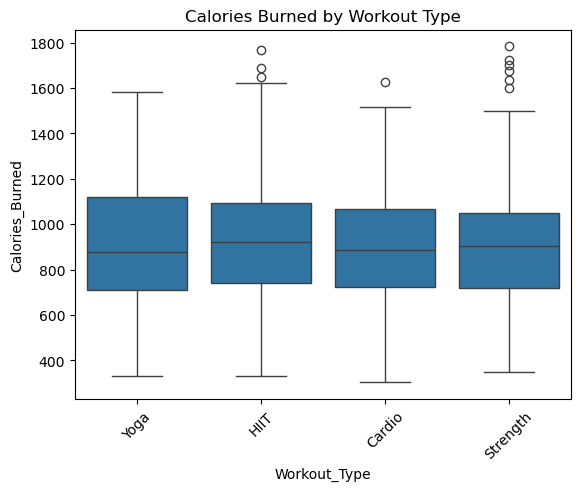

In [365]:
#Boxplot showing calories burned per workout
sns.boxplot(x='Workout_Type', y='Calories_Burned', data=gym_data)
plt.title('Calories Burned by Workout Type')
plt.xticks(rotation=45)
plt.show()

* There are some outliers in the dataset - if the model can't handle the outliers I will remove these later on however at this stage will keep them in. 

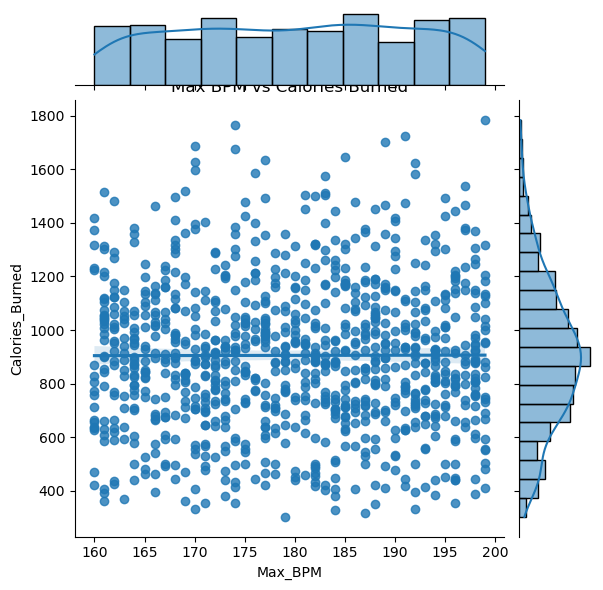

In [368]:
#Jointplot of the Max_BPM and claories burned
sns.jointplot(x='Max_BPM', y='Calories_Burned', data=gym_data, kind='reg')
plt.title('Max BPM vs Calories Burned')
plt.show()

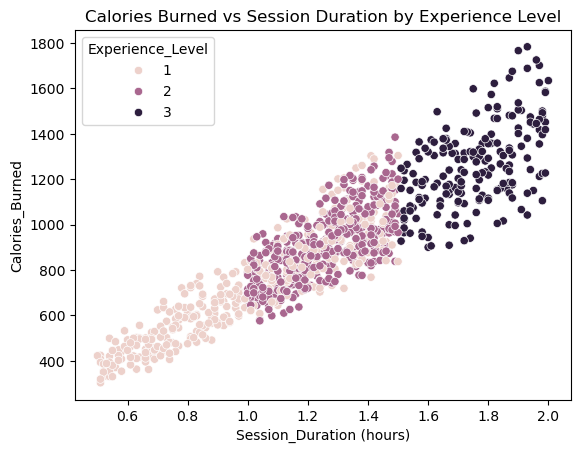

In [370]:
#Calroies burned with session duration and experience plot
sns.scatterplot(x='Session_Duration (hours)', y='Calories_Burned', hue='Experience_Level', data=gym_data)
plt.title('Calories Burned vs Session Duration by Experience Level')
plt.show()

## Data Pre-Processing

In [373]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [375]:
#Encode the non-numeric and experience level columns
label_encoders = {}
for column in ['Gender', 'Workout_Type', 'Experience_Level']:
    le = LabelEncoder()
    gym_data[column] = le.fit_transform(gym_data[column])
    label_encoders[column] = le

In [377]:
gym_data.shape

(973, 15)

In [379]:
# Normalising the numerical features in preparation for building the model
scaler = StandardScaler()
numerical_features = gym_data.select_dtypes(include=["int64","float64"]).columns
gym_data[numerical_features] = scaler.fit_transform(gym_data[numerical_features])

## Building a model

In [382]:
# Choosing the target variable
X = gym_data.drop(columns=['Calories_Burned'])  
y = gym_data['Calories_Burned'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [384]:
reg = LinearRegression().fit(X_train, y_train)

In [386]:
#Looking at how the model performs
reg.score(X_test, y_test)

0.9803427065691752

In [388]:
# Check Coeffiricent
reg.coef_

array([-0.14817397,  0.15174836, -0.08022136,  0.05150138,  0.00444431,
        0.32404721,  0.01620777,  0.89705548, -0.00987676, -0.01419088,
       -0.00796104,  0.0137094 , -0.01020968,  0.08382084])

In [390]:
def view_coeff(X, reg,figsize=(15, 8)):
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': reg.coef_,
                                'abs_coef': np.abs(reg.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    sns.barplot(x="variable", y="coef", data=model_coefs)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

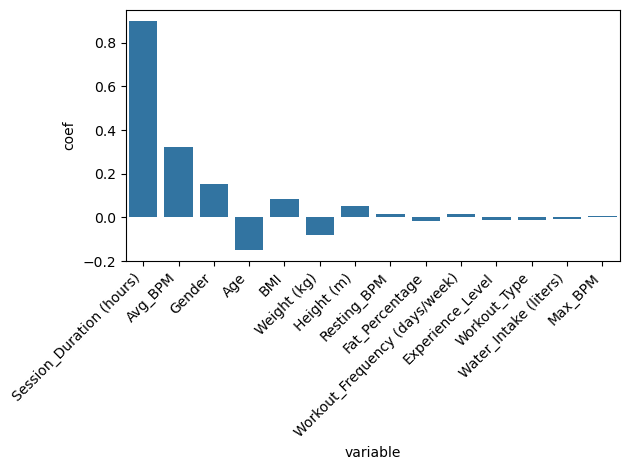

In [392]:
view_coeff(X, reg, figsize=(15, 8))

## Penalising the model with Lasso/Ridge

In [395]:
## Calculate Ridge Regression model
# create a model object to hold the modelling parameters
ridgemodel = Ridge()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
ridge_alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in ridge_alphas:
    ridgemodel.set_params(alpha = a)
    ridgemodel.fit(X_train, y_train)
    coefs.append(ridgemodel.coef_)
    errors.append(mean_squared_error(ridgemodel.coef_, reg.coef_))

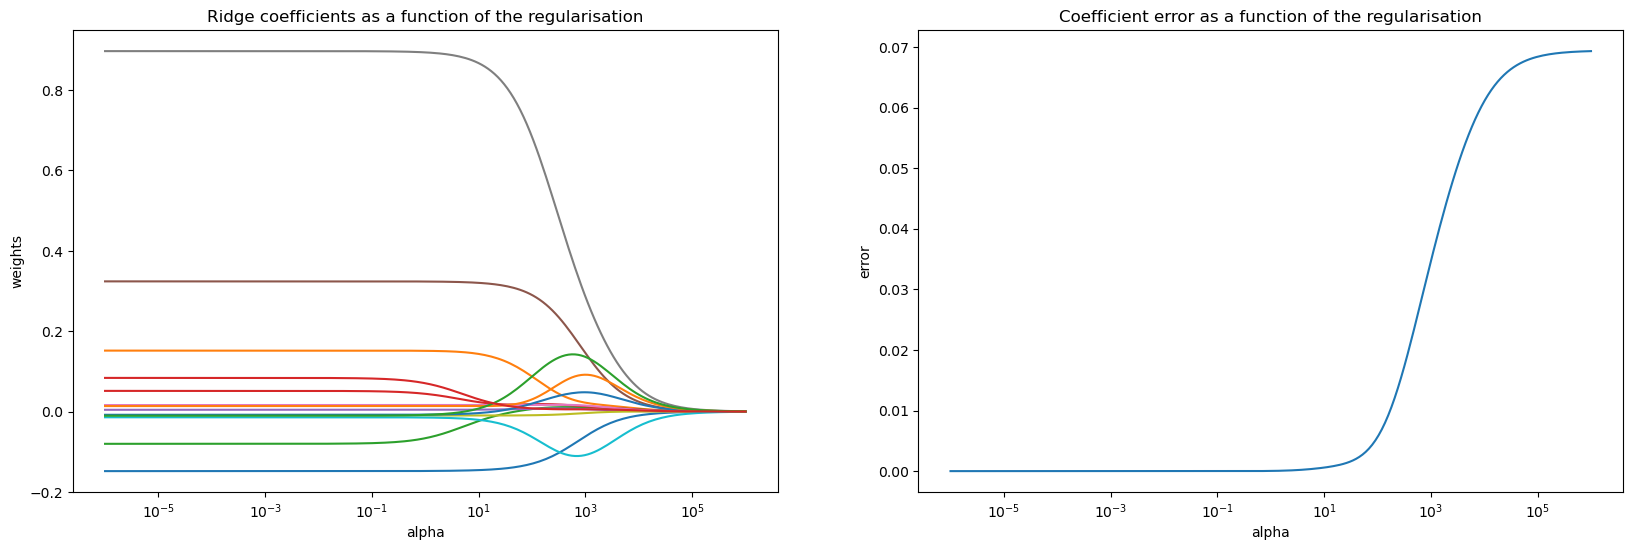

In [397]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(ridge_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(ridge_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

In [399]:
#Find an optimal value for Ridge regression alpha using RidgeCV
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)
print('Alpha:', optimal_ridge.alpha_)
print('Score:', optimal_ridge.score(X_train, y_train))

Alpha: 0.3072112998861753
Score: 0.9788902420794439


In [400]:
## Calculate Lasso Regression model
# create a model object to hold the modelling parameters
lassomodel = Lasso()

# keep track of the intermediate results for coefficients and errors
coefs = []
errors = []

# create a range of alphas to calculate
lasso_alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in lasso_alphas:
    lassomodel.set_params(alpha = a)
    lassomodel.fit(X_train, y_train)
    coefs.append(lassomodel.coef_)
    errors.append(mean_squared_error(lassomodel.coef_, reg.coef_))

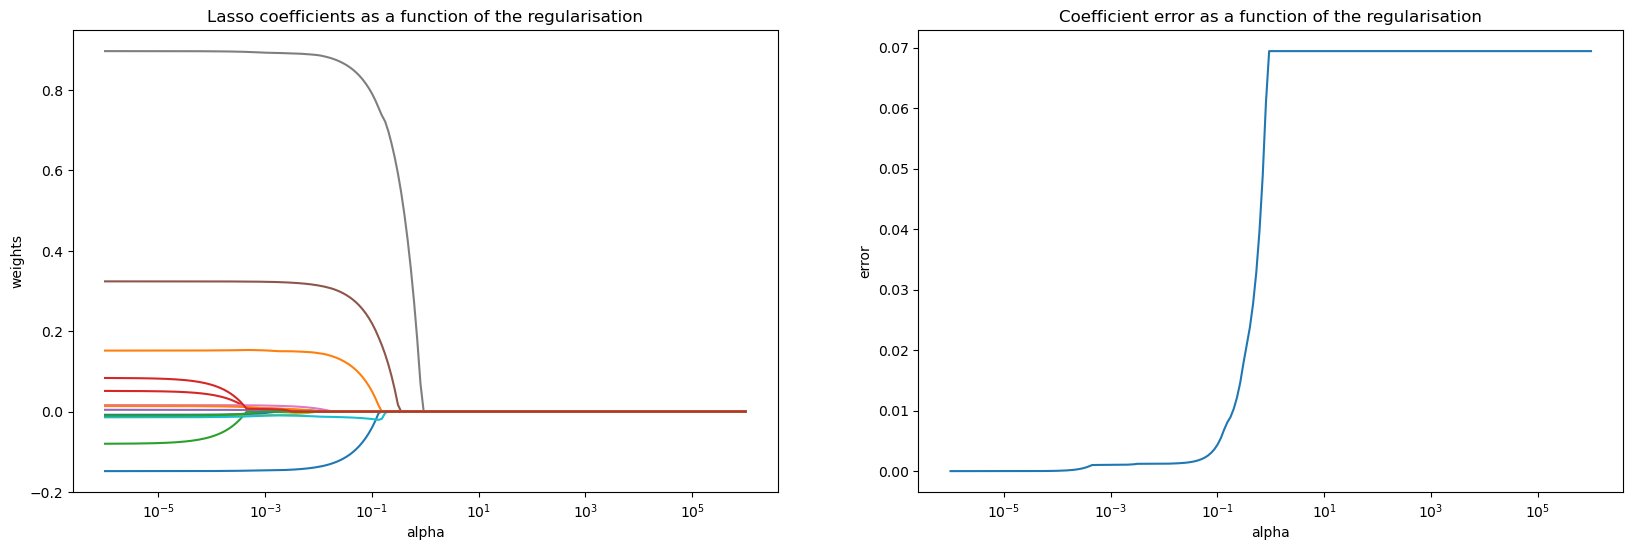

In [402]:
# Display results
plt.figure(figsize = (20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(lasso_alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularisation')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(lasso_alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularisation')
plt.axis('tight')

plt.show()

In [405]:
#Finding an optimal value for Lasso regression alpha using LassoCV
optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10)
optimal_lasso.fit(X_train, y_train)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', optimal_lasso.score(X_train, y_train))

Alpha: 1e-06
Score: 0.9788909755230747


## Hyperparameter Tuning

In [412]:
#Building Ridge/Lasso models with GridearchCV

from sklearn.model_selection import GridSearchCV

# 1. Ridge Regression
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)

# 2. Lasso Regression
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'selection': ['cyclic', 'random']
}

lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)

# Print best parameters and scores for each model
models = {
    'Ridge': ridge_grid,
    'Lasso': lasso_grid,
}

for name, model in models.items():
    print(f"\n{name} Regression Results:")
    print("Best parameters:", model.best_params_)
    print("Best score:", np.sqrt(-model.best_score_))  # Converting MSE to RMSE
    
    # Make predictions and evaluate on test set
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R2: {test_r2:.4f}")


Ridge Regression Results:
Best parameters: {'alpha': 0.1, 'solver': 'sag'}
Best score: 0.14643472204680522
Test RMSE: 0.1486
Test R2: 0.9803

Lasso Regression Results:
Best parameters: {'alpha': 0.001, 'selection': 'random'}
Best score: 0.14663103334527616
Test RMSE: 0.1488
Test R2: 0.9803


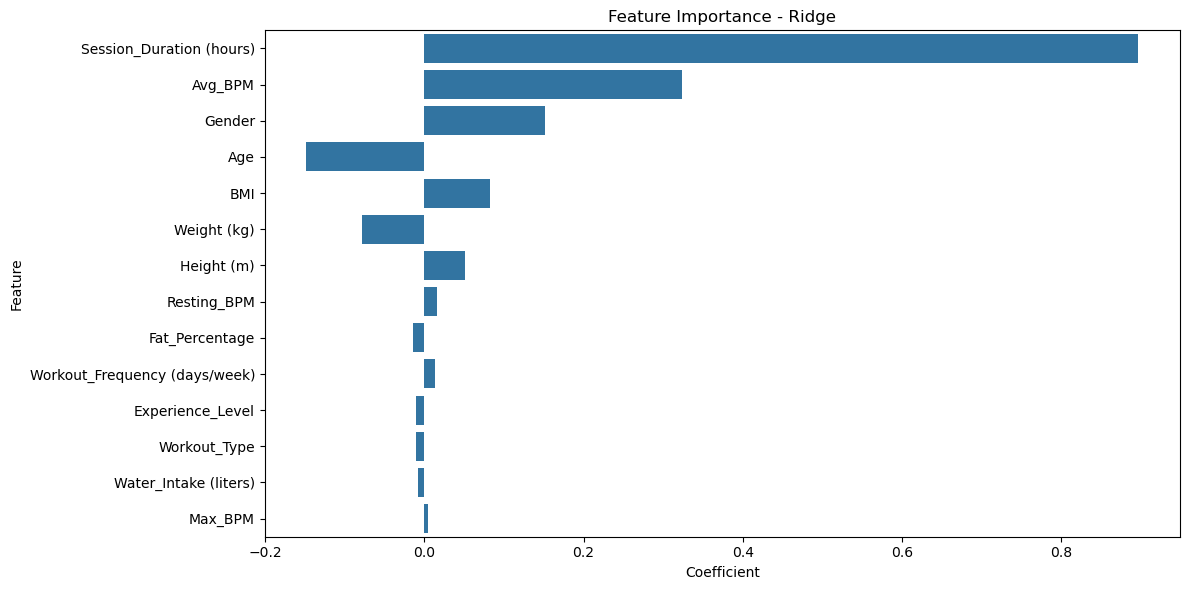

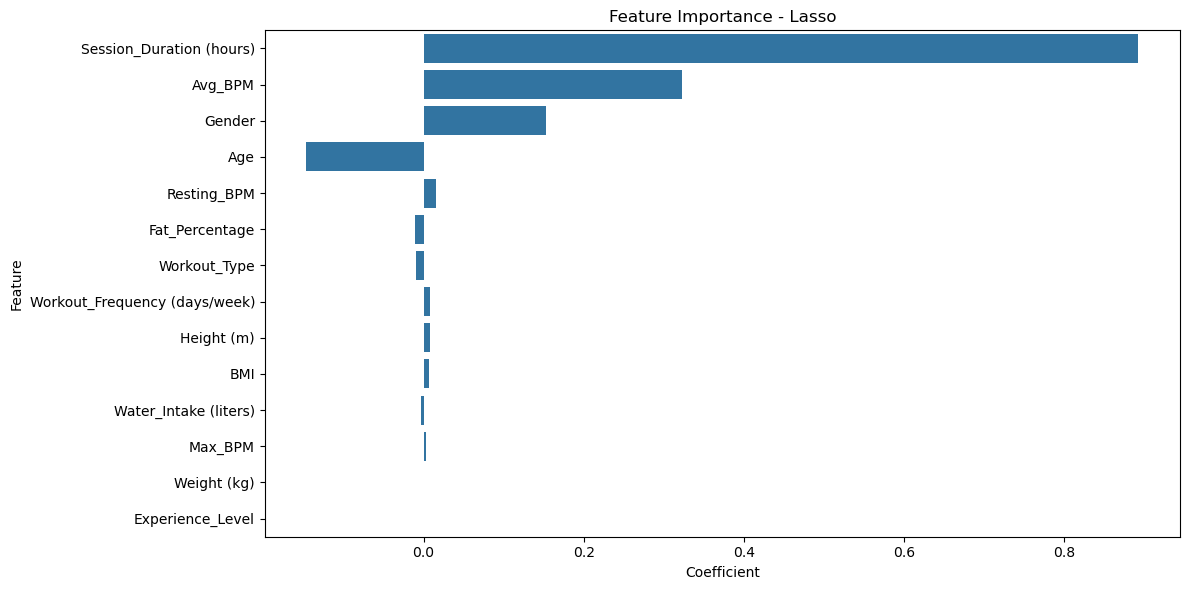

In [414]:
def plot_feature_importance(model, X, title):
    # Get feature coefficients
    coef = model.best_estimator_.coef_
    
    # Create DataFrame of features and their coefficients
    feat_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coef
    })
    
    # Sort by absolute coefficient value
    feat_importance['Abs_Coefficient'] = abs(feat_importance['Coefficient'])
    feat_importance = feat_importance.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Coefficient', y='Feature', data=feat_importance)
    plt.title(f'Feature Importance - {title}')
    plt.tight_layout()
    plt.show()

# Plot feature importance for each model
for name, model in models.items():
    plot_feature_importance(model, X_train, name)